In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [ ]:
df = pd.read_csv('nyc_taxi_3.csv')

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f875ae0e470>,
      dtype=object)

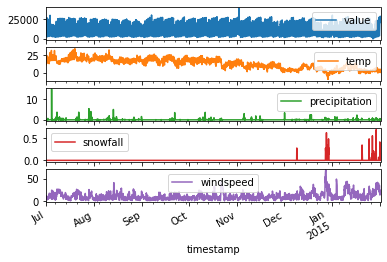

In [ ]:
df.set_index('timestamp')[['value', 'temp', 'precipitation', 'snowfall', 'windspeed']].plot(subplots=True)

In [ ]:
df_input = df[['value', 'temp', 'precipitation', 'snowfall', 'windspeed']]
# new data frame to be input.

In [ ]:
# df_input

In [ ]:
# df_input.describe()

In [ ]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_input)
# scaler to change the values from real values to 0-1
# before fitting, gradient can convert faster,
# no scale, too much time taking.


In [ ]:
# df_scaled

In [ ]:
# df_scaled # bet 0 and 1
# scaled the input data starting from
# value, temp, precipitation, snowfall, windspeed

In [ ]:
features = df_scaled
# 'feature' has all the external features!
# features()
target = df_scaled[:,0]
# target is only the 'value' of passengers out of external features
# 첫번째 컬럼만 보겠다 !target!
features

array([[0.27650616, 0.54411425, 0.        , 0.        , 0.05912408],
       [0.1582587 , 0.52292097, 0.        , 0.        , 0.05912408],
       [0.09727219, 0.50886891, 0.        , 0.        , 0.04892014],
       ...,
       [0.60504223, 0.25132457, 0.        , 0.        , 0.28045014],
       [0.656128  , 0.2402672 , 0.        , 0.        , 0.22152572],
       [0.6783281 , 0.2252937 , 0.        , 0.        , 0.23836499]])

In [ ]:
# target

In [ ]:
# features

In [ ]:
TimeseriesGenerator(features, target, length=2, sampling_rate=1, batch_size=1)[0]
# length, time period x 2 this means, in this case, 2 hours and next 2 hours
# first 2 time periods are inputs and the third one is the output prediction
# so for my case, input is 2 hours of value and 3th hour is the predicted value
# 0.09727219 = the prediction value of the passenger

(array([[[0.27650616, 0.54411425, 0.        , 0.        , 0.05912408],
         [0.1582587 , 0.52292097, 0.        , 0.        , 0.05912408]]]),
 array([0.09727219]))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123, shuffle=False)
# split data, testsize=20%, shuffle=false--> order is important!!

In [ ]:
# x_train.shape
# Training dataset is 4128 which is 5160 * 80%


In [ ]:
# x_test.shape
# and test dataset is 1032 which is 5160 * 20% and 5 features

In [ ]:
# y_train.shape

In [ ]:
# y_test.shape

In [ ]:
win_length = 168 # 7 * 24 7 days, 24 hours
# With 7 days of win_length, I will predict the next 
batch_size = 32
num_features = 5
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
# Passing 80% of training data 
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)
# Passing 20% of Training data
# "Timeseries generator first apply and split data"


In [ ]:
type(train_generator)


tensorflow.python.keras.preprocessing.sequence.TimeseriesGenerator

In [ ]:
# test_generator
# len(train_generator)
#first=input, second=target


In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(win_length, num_features), return_sequences=True))
#input shape = 100 win_length and 5 features
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))         # L1
#activation function
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))         # L2
# model.add(tf.keras.layers.Dropout(0.3))

# avoid overfit
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))               # L3
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 168, 128)          68608     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 168, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 168, 128)          131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 168, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min')
# I dont want all epochs to run, so I will stop
# whenever val_loss is not getting better twice in a row 

model.compile(loss=tf.losses.MeanSquaredError(),
             optimizer=tf.optimizers.Adam(),
             metrics=[tf.metrics.MeanAbsolutePercentageError(), tf.metrics.MeanAbsoluteError()] )

history = model.fit_generator(train_generator, epochs=50,
                             validation_data=test_generator,
                             shuffle=False, callbacks=[early_stopping])
# Passing traing data(80%), 
#One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE
#- batch size : Total number of training examples present in a single batch

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
124/124 [==============================] - 60s 483ms/step - loss: 0.0359 - mean_absolute_percentage_error: 81.0513 - mean_absolute_error: 0.1547 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 431008.7188 - val_mean_absolute_error: 0.1210
Epoch 2/50
124/124 [==============================] - 58s 471ms/step - loss: 0.0192 - mean_absolute_percentage_error: 53.1190 - mean_absolute_error: 0.1123 - val_loss: 0.0157 - val_mean_absolute_percentage_error: 365592.0312 - val_mean_absolute_error: 0.0997
Epoch 3/50
124/124 [==============================] - 59s 476ms/step - loss: 0.0122 - mean_absolute_percentage_error: 37.1110 - mean_absolute_error: 0.0860 - val_loss: 0.0118 - val_mean_absolute_percentage_error: 279441.0938 - val_mean_absolute_error: 0.0834
Epoch 4/50
124/124 [==============================] - 59s 474ms/step - loss: 0.0095 - mean_absolute_percentage_error: 30.5120 - mean_absolute_error

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 168, 128)          68608     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 168, 128)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 168, 128)          131584    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 168, 128)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
model.evaluate_generator(test_generator, verbose=0)
# 0.04575 = mean absolute error

[0.004236473701894283, 270461.8125, 0.049753595143556595]

In [ ]:
predictions = model.predict_generator(test_generator)
# predictions will be compared to test_generator and shape

In [ ]:
predictions.shape[0]
# predictions = predictions[0].shape
# difference with window_size
# test dataset was originally 1032, 
# so 1032 subtract 100 is 932 which is the windowsize removed to predict the rest
# It will take first 100 window size and predict the rest

864

In [ ]:
predictions.shape[0]

864

In [ ]:
predictions

array([[ 0.2685434 ],
       [ 0.2236543 ],
       [ 0.17742203],
       [ 0.14376368],
       [ 0.12235145],
       [ 0.12030584],
       [ 0.10822637],
       [ 0.17689323],
       [ 0.26497942],
       [ 0.3374642 ],
       [ 0.38802555],
       [ 0.4064272 ],
       [ 0.43926096],
       [ 0.4559281 ],
       [ 0.46514153],
       [ 0.43769473],
       [ 0.47168058],
       [ 0.4037271 ],
       [ 0.43022734],
       [ 0.46451342],
       [ 0.47899905],
       [ 0.44508427],
       [ 0.4869818 ],
       [ 0.5105954 ],
       [ 0.44919497],
       [ 0.40452844],
       [ 0.31985706],
       [ 0.26148003],
       [ 0.19629171],
       [ 0.16810624],
       [ 0.130415  ],
       [ 0.16571379],
       [ 0.28058305],
       [ 0.36981183],
       [ 0.40248543],
       [ 0.4282177 ],
       [ 0.44891423],
       [ 0.4621513 ],
       [ 0.46909422],
       [ 0.45247507],
       [ 0.44174844],
       [ 0.42553145],
       [ 0.40130293],
       [ 0.42215508],
       [ 0.43438223],
       [ 0

In [ ]:
len(y_test)
# just the value of passengers

# x_test = all features included = 1032
# y_test = just the value of passengers = 1032

1032

In [ ]:
x_test.shape

(1032, 5)

In [ ]:
len(x_test)

1032

In [ ]:
test_win_length_after = x_test[:,1:][win_length:]

# take the first column til the end and ignore the first 168 dataset
# Prediction will not have the rest of it. 

In [ ]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(test_win_length_after)],axis=1)
# going to take all the x_test and concate with predictions
# predicted value at first column + x_test

In [ ]:
df_pred

,0,0,1,2,3
0,0.268543,0.202488,0.000000,0.0,0.109879
1,0.223654,0.210781,0.000000,0.0,0.116530
2,0.177422,0.220917,0.000000,0.0,0.130877
3,0.143764,0.233817,0.000000,0.0,0.143049
4,0.122351,0.266298,0.000000,0.0,0.167950
...,...,...,...,...,...
859,0.638588,0.275282,0.013514,0.2,0.301475
860,0.622267,0.259848,0.000000,0.0,0.300760
861,0.563246,0.251325,0.000000,0.0,0.280450
862,0.614000,0.240267,0.000000,0.0,0.221526


In [ ]:
rev_trans=scaler.inverse_transform(df_pred)
#scaled value will be changed to predicted value


In [ ]:
rev_trans

array([[ 1.05319470e+04, -4.59471340e-01,  0.00000000e+00,
         0.00000000e+00,  7.62826300e+00],
       [ 8.77278836e+03, -9.94713400e-02,  0.00000000e+00,
         0.00000000e+00,  8.08999300e+00],
       [ 6.96099200e+03,  3.40528670e-01,  0.00000000e+00,
         0.00000000e+00,  9.08598800e+00],
       ...,
       [ 2.20810339e+04,  1.66052870e+00,  0.00000000e+00,
         0.00000000e+00,  1.94699760e+01],
       [ 2.40700422e+04,  1.18052860e+00,  0.00000000e+00,
         0.00000000e+00,  1.53792060e+01],
       [ 2.59617298e+04,  5.30528660e-01,  0.00000000e+00,
         0.00000000e+00,  1.65482560e+01]])

In [ ]:
df_final = df_input[predictions.shape[0]*-1:]
#80% training, left is prediction, bottom to top

In [ ]:
df_final.count()

value            864
temp             864
precipitation    864
snowfall         864
windspeed        864
dtype: int64

In [ ]:
df_final['Passenger_Pred_value'] = rev_trans[:,0]
# predicted value of passengers, attaching to df_final

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_final

,value,temp,precipitation,snowfall,windspeed,Passenger_Pred_value
4296,13396,-0.459471,0.0,0.00,7.628263,10531.947006
4297,11298,-0.099471,0.0,0.00,8.089993,8772.788362
4298,9368,0.340529,0.0,0.00,9.085988,6960.992003
4299,7493,0.900529,0.0,0.00,9.931042,5641.954710
4300,5928,2.310529,0.0,0.00,11.659777,4802.831080
...,...,...,...,...,...,...
5155,28804,2.700529,0.2,0.14,20.929596,25033.641924
5156,24985,2.030528,0.0,0.00,20.880001,24394.019434
5157,23719,1.660529,0.0,0.00,19.469976,22081.033939
5158,25721,1.180529,0.0,0.00,15.379206,24070.042207


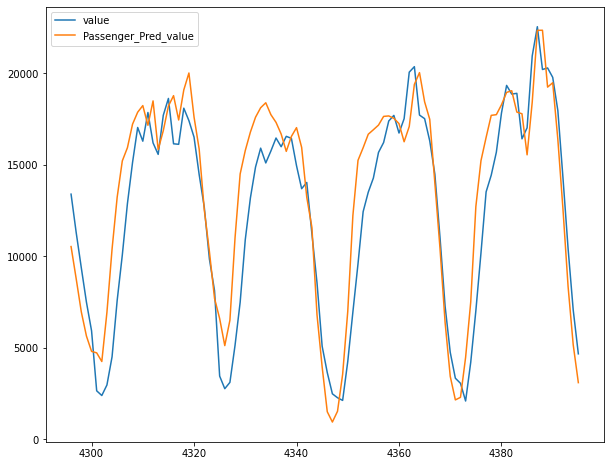

In [ ]:
df_final[['value','Passenger_Pred_value']][:100].plot()

In [ ]:
import numpy as np
import pandas as pd
df_final = pd.DataFrame(df_final, columns=['Passenger_Pred_value']).to_csv('prediction_LSTM.csv')